In [69]:
import networkx as nx
from __future__ import division

import numpy as np

from matplotlib import pyplot as plt



def basestation(graph):                #选定一个basesation 返回这个node
    dic=nx.to_dict_of_lists(graph)
    for i in range(nx.number_of_nodes(graph)):
        mylist=dic[i]
        if (len(mylist)!=0):
            break
    
    return i



def neiboredge(G,j,i):            #返回除了i 以外j的neiborlist  邻接参数的导数和
    neiborlist=[m for m in G.successors(j) if m!=i]
    if len(neiborlist)==0:
        return [0,[],100000000]
    else:
        updatelist=[1/G.edge[m][j]['flow'] for m in neiborlist]
        return [len(neiborlist),neiborlist,sum(updatelist),updatelist]
        
        
def neiborpara(G,j,i):            #返回除了i 以外j的neiborlist  邻接参数的导数和
    neiborlist=[m for m in G.successors(j) if m!=i]
    if len(neiborlist)==0:
        return [0,[],0]
    else:
        updatelist=[G.edge[m][j]['para'] for m in neiborlist]
        return [len(neiborlist),neiborlist, sum(updatelist)]        
        
        
        
        
def cavity_method(G,UG):
    base=basestation(G)
    
    
    # 计算势能的预处理
    lapalacian=nx.laplacian_matrix(UG,weight='rsistance')
    A=lapalacian.todense()  
    dim=int(np.sqrt(A.size))
    mylist=[]
 
    
    for i in range(dim):
        for j in range(dim):
            if(i !=base and j!=base):
                mylist.append(A[i,j])
            
            
    modify_lapalacian=np.array(mylist).reshape(dim-1,dim-1)
    vectorP=[G.node[node]['source'] for node in G.nodes() if node!=base]
    vectorP=np.array(vectorP)
    chemical=np.linalg.solve(modify_lapalacian,vectorP)
    chemical=np.insert(chemical,base,0)  #numpy插入元素
    for node in G.nodes():
        G.node[node]['chemical']=chemical[node]
  

   
#   开始cavity method 
    
    
    for (j,i) in G.edges():
        if (j==base):
            G.edge[j][i]['flow']=G.edge[j][i]['rsistance']
            G.edge[j][i]['para']=0
            
            #a=G.edge[j][i]['flow']
            # print(' bamessage is %f'%a)
            # print(j,i)
            
        elif (neiboredge(G,j,i)[0]==0):
            
            G.edge[j][i]['flow']=10000000
            G.edge[j][i]['para']=G.node[j]['source']
            #a=G.edge[j][i]['flow']
            
            # print(' single message is %f'%a)   不要用点，用这样的方法取消注释
            # print(j,i)
                
                
        else:
            a=neiboredge(G,j,i)[2]
            
            #G.edge[j][i]['flow']=1/(a+)+ G.edge[j][i]['rsistance']
            G.edge[j][i]['flow']=1/(a)+ G.edge[j][i]['rsistance'] 
            
                
            
    
            
            b=neiborpara(G,j,i)[2]
            G.edge[j][i]['para']=(G.node[j]['source']+b)/(1+G.edge[j][i]['rsistance']*a)         
            
            # print(' message is %f'%((G.edge[j][i]['flow'])))
            # print(j,i)
            
        G.edge[j][i]['cavity flow']=(G.edge[j][i]['flow']*G.edge[j][i]['para']-G.edge[i][j]['flow']*G.edge[i][j]['para'])/(G.edge[i][j]['flow']+G.edge[j][i]['flow']-G.edge[i][j]['rsistance']) 
        G.edge[j][i]['real flow']=(G.node[j]['chemical']-G.node[i]['chemical'])/G.edge[i][j]['rsistance']
        
        cavity_energy=0
        real_energy=0
        for (u,v) in G.edges():
            cavity_energy=cavity_energy+1/2*G.edge[u][v]['rsistance']*G.edge[u][v]['cavity flow']**2
            real_energy=real_energy+1/2*G.edge[u][v]['rsistance']*G.edge[u][v]['real flow']**2
            
        G.graph['cavity_energy']=cavity_energy/2
        G.graph['real_energy']=real_energy/2
               
    return  G     

In [26]:
UUG=nx.Graph()
UUG.graph['cavity_energy']=0
UUG.graph['real_energy']=0


UUG.add_nodes_from([0,1,2,3,4])
UUG.add_edges_from([(0,1),(1,2),(0,2),(2,3),(3,4)])

for i in UUG.nodes():
    
    UUG.node[i]['chemical']=0
    UUG.node[i]['source']=np.random.randint(-10,10) 
    
for (u,v) in UUG.edges():
    UUG.edge[u][v]['flow']=np.random.random()+1
    UUG.edge[u][v]['rsistance']=1
    UUG.edge[u][v]['para']=np.random.randint(1,4)
    UUG.edge[u][v]['real flow']=0
    UUG.edge[u][v]['cavity flow']=0
    

    
base=basestation(UUG)    
    
UUG.node[base]['source']=-sum([UUG.node[m]['source'] for m in UUG.nodes() if m!=base ])   


DUUG=UUG.to_directed()

In [27]:
reallist=[]
cavitylist=[]



for i in range(200):
    

    print(DUUG.graph['real_energy'],DUUG.graph['cavity_energy'])
    reallist.append(DUUG.graph['real_energy'])
    cavitylist.append(DUUG.graph['cavity_energy'])
    DUUG=cavity_method(DUUG,UUG)
    

0 0
393.333333333 45.373806945872694
393.333333333 135.6108775486972
393.333333333 275.5962251530319
393.333333333 371.65023127440156
393.333333333 393.33319722225906
393.333333333 393.33319722225906
393.333333333 393.33319722225906
393.333333333 393.33319722225906
393.333333333 393.33319722225906
393.333333333 393.33319722225906
393.333333333 393.33319722225906
393.333333333 393.33319722225906
393.333333333 393.33319722225906
393.333333333 393.33319722225906
393.333333333 393.33319722225906
393.333333333 393.33319722225906
393.333333333 393.33319722225906
393.333333333 393.33319722225906
393.333333333 393.33319722225906
393.333333333 393.33319722225906
393.333333333 393.33319722225906
393.333333333 393.33319722225906
393.333333333 393.33319722225906
393.333333333 393.33319722225906
393.333333333 393.33319722225906
393.333333333 393.33319722225906
393.333333333 393.33319722225906
393.333333333 393.33319722225906
393.333333333 393.33319722225906
393.333333333 393.33319722225906
393.3333

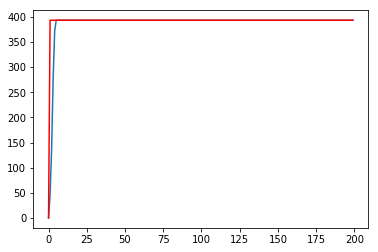

In [30]:
z=[i for i in range(200)]
x=reallist
y=cavitylist

plt.plot(z,y)
plt.plot(z,x,color='r')
plt.show()



/Users/wangzai/Applications/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/wangzai/Applications/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/wangzai/Applications/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/wangzai/Applications/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is depreca

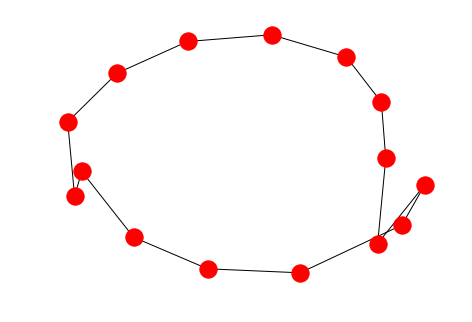

In [32]:
CG=nx.cycle_graph(15)
nx.draw(CG)
plt.show()

In [36]:
CG.graph['cavity_energy']=0
CG.graph['real_energy']=0

for i in CG.nodes():
    
    CG.node[i]['chemical']=0
    CG.node[i]['source']=np.random.randint(-10,10) 
    
for (u,v) in CG.edges():
    CG.edge[u][v]['flow']=np.random.random()+1
    CG.edge[u][v]['rsistance']=1
    CG.edge[u][v]['para']=np.random.randint(1,4)
    CG.edge[u][v]['real flow']=0
    CG.edge[u][v]['cavity flow']=0
    

    
base=basestation(CG)    
    
UUG.node[base]['source']=-sum([CG.node[m]['source'] for m in CG.nodes() if m!=base ])   



reallist1=[]
cavitylist1=[]

DCG=CG.to_directed()
for i in range(30):

    
    
    print(DCG.graph['real_energy'],DCG.graph['cavity_energy'])
    DUUG=cavity_method(DCG,CG)

0 0
920.666666667 636.2531824210582
920.666666667 629.8739650674844
920.666666667 577.9372717122906
920.666666667 564.9148087112034
920.666666667 585.4876420358364
920.666666667 627.6115853358584
920.666666667 681.0398334131911
920.666666667 733.1847594520333
920.666666667 785.5462090403889
920.666666667 838.2468535323638
920.666666667 872.1582992148234
920.666666667 892.5326914624274
920.666666667 910.281529015003
920.666666667 919.2665809256027
920.666666667 920.6666666666667
920.666666667 920.6666666666667
920.666666667 920.6666666666667
920.666666667 920.6666666666667
920.666666667 920.6666666666667
920.666666667 920.6666666666667
920.666666667 920.6666666666667
920.666666667 920.6666666666667
920.666666667 920.6666666666667
920.666666667 920.6666666666667
920.666666667 920.6666666666667
920.666666667 920.6666666666667
920.666666667 920.6666666666667
920.666666667 920.6666666666667
920.666666667 920.6666666666667


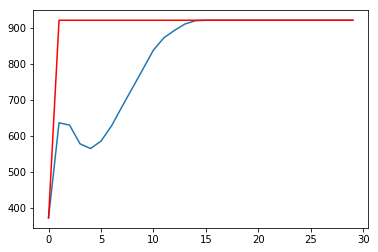

In [40]:
z=[i for i in range(30)]
plt.plot(z,cavitylist1)
plt.plot(z,reallist1,color='r')
plt.show()

In [119]:
RG=nx.fast_gnp_random_graph(30,0.15)
RG.graph['cavity_energy']=0
RG.graph['real_energy']=0
for i in RG.nodes():
    
    RG.node[i]['chemical']=0
    RG.node[i]['source']=np.random.randint(-10,10) 
    
for (u,v) in RG.edges():
    RG.edge[u][v]['flow']=np.random.random()+1
    RG.edge[u][v]['rsistance']=1
    RG.edge[u][v]['para']=np.random.randint(1,4)
    RG.edge[u][v]['real flow']=0
    RG.edge[u][v]['cavity flow']=0
    

base=basestation(CG)    
    
RG.node[base]['source']=-sum([RG.node[m]['source'] for m in RG.nodes() if m!=base ])   



reallist1=[]
cavitylist1=[]

DRG=RG.to_directed()
for i in range(50):
    reallist1.append(DRG.graph['real_energy'])
    cavitylist1.append(DRG.graph['cavity_energy'])
    print(DRG.graph['real_energy'],DRG.graph['cavity_energy'])
    DRG=cavity_method(DRG,RG)



0 0
266.418579652 144.13678485310191
266.418579652 256.81100957163017
266.418579652 248.90773976442438
266.418579652 243.5311814038522
266.418579652 244.75798342152098
266.418579652 244.37710141516723
266.418579652 244.0242950672352
266.418579652 244.66906436841728
266.418579652 245.6020310058585
266.418579652 246.6791968347509
266.418579652 247.87722140820168
266.418579652 249.13901152714087
266.418579652 250.4130108966822
266.418579652 251.6679084967365
266.418579652 252.88239793830664
266.418579652 254.04166449578418
266.418579652 255.13626286838726
266.418579652 256.16098249947095
266.418579652 257.11364853779816
266.418579652 257.99427608857474
266.418579652 258.8044471926257
266.418579652 259.54682688334896
266.418579652 260.2247900902231
266.418579652 260.84214287700746
266.418579652 261.4029150636846
266.418579652 261.9112076544703
266.418579652 262.37108272408705
266.418579652 262.7864859988294
266.418579652 263.16119433624647
266.418579652 263.4987820563157
266.418579652 263.

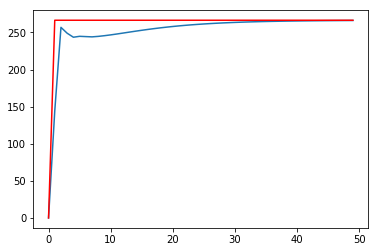

In [120]:
z=[i for i in range(50)]
x=reallist1
y=cavitylist1

plt.plot(z,y)
plt.plot(z,x,color='r')
plt.show()